#Módulo 2 Implementación de un modelo de deep learning

Natalia Duarte Corzo - A01745482

##Introducción

A lo largo de los años, deep learning ha tenido una expansión notable, utilizándose cada vez más con el fin de solucionar problemas de nuestra vida cotidiana y de esta manera optimizar y transformar nuestras vidas. A través de los modelos de deep learning podemos procesar datos de diversas áreas e identificar patrones o características en ellos, que nos ayuden a la resolver lo deseado.

Así pues, para esta actividad, seleccioné una base de datos de señalamientos de manos, en este caso, de las señales piedra, papel o tijera, que se utilizan para jugar, con el fin de generar un modelo capaz de identificar que señalamiento se esta realizando. Se pensó que este modelo podría después aplicarse al lenguaje de señas, con el fin de que identifiqué qué letras están generando con las manos y, de está manera identificar qué se está queriendo decir.Cabe mencionar, que esto se intentó realizar inicialmente pero, se tuviero limitaciones por la capacidad del RAM

In [1]:
#Importación de librerías
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop


##Carga y visualización de datos

Primeramente, se realiza la carga de datos, de una base seleccionada de la plataforma de kaggle, con el fin de identificar la calidad de imágenes y, las tres distintas categorías que existen, siendo estas piedra, papel o tijera. Cabe mencionar que, todas las imágenes tienen el tamaño de 300x300, lo cuál será útil en los siguientes pasos.

In [2]:
!mkdir -p /root/.kaggle
!cp '/content/drive/MyDrive/Semestre 7/Blumenkron/kaggle.json' /root/.kaggle/

In [3]:
!kaggle datasets download -d sanikamal/rock-paper-scissors-dataset
path = '/content/rock-paper-scissors-dataset.zip'
with zipfile.ZipFile(path,'r')as zip_ref:
  zip_ref.extractall('/content/')


100% 452M/452M [00:06<00:00, 113MB/s]
100% 452M/452M [00:06<00:00, 78.3MB/s]


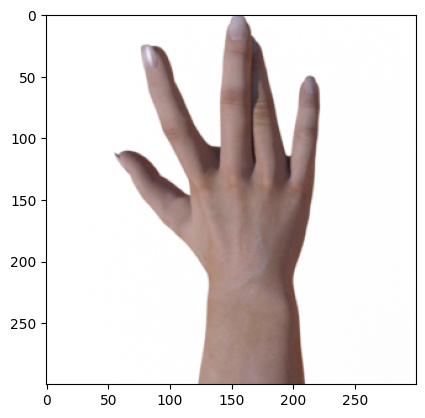

In [4]:
imagen = '/content/rock-paper-scissors/Rock-Paper-Scissors/train/paper/paper01-000.png'
img = mpimg.imread(imagen)
plt.imshow(img)

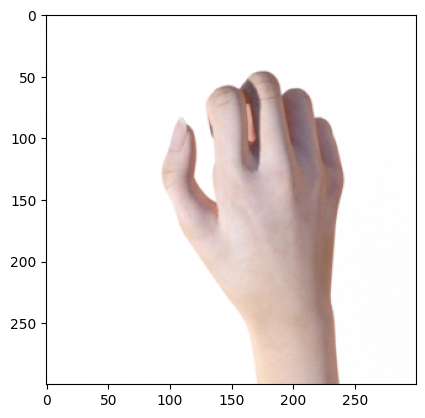

In [5]:
imagen = '/content/rock-paper-scissors/Rock-Paper-Scissors/train/rock/rock01-000.png'
img = mpimg.imread(imagen)
plt.imshow(img)

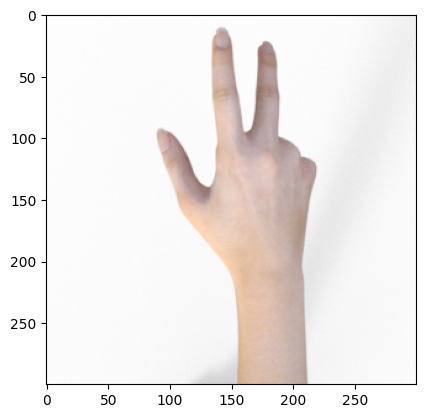

In [6]:
imagen = '/content/rock-paper-scissors/Rock-Paper-Scissors/train/scissors/scissors01-000.png'
img = mpimg.imread(imagen)
plt.imshow(img)

##Creación de etiquetas

Un detalle que se identificó en esta base es que los datos de validación estaban en una sola carpeta, sin separarse por categoría, por lo que se hace un código para juntar las imagenes en su clase correspondiente (piedra, papel o tijera), con el fin de identificar cuántas imágenes se tiene en cada una de ellas

In [7]:
#Importamos las librerías que sirven para trabajar sobre directorios y manipular archivos
import os
import shutil

directorio = '/content/rock-paper-scissors/Rock-Paper-Scissors/validation'
imagenes = os.listdir(directorio)#lectura de los nombres de las imágenes, pasamos todos a una lista
categorias = ['rock', 'paper', 'scissors']#definimos las categorías como con los mismos nombres que las carpetas de train y test

for nombre in imagenes:
    image_path = os.path.join(directorio, nombre)
    if os.path.isfile(image_path):
        for categoria in categorias:
            if categoria in nombre:
                categoria_directorio = os.path.join(directorio, categoria)
                if not os.path.exists(categoria_directorio):
                    os.makedirs(categoria_directorio)
                shutil.move(image_path, os.path.join(categoria_directorio, nombre)) # Se van moviendo las imagenes conforme a su nombre a la categoría correspondiente
    else:
        print(f"{nombre} is not a file.")



 A continuación se utiliza ImageGenerator, de keras, para crear los generadores de datos para cada conjunto, siendo estos el conjunto de entrenamiento, de prueba y, de validación. Así pues, lo que se hace es cargar las imágenes desde su directorio, redimensionarlas y normalizarlas, para después ordenarlas por lotes y poder hacer el entrenamiento del modelo

In [8]:
#Hacemos el generador, el cual va a normalizar los píxeles de las imágenes escalándolos entre 0 y 1
datagen = ImageDataGenerator(rescale=1./255)

#Definimos el tamaño del lote y, de las imagenes
batch_size = 32
img_height, img_width = 300, 300  #tomamos en cuenta el tamaño de imagenes que se define en la pagina de kaggle

#Se crean generadores para cargar nuestras imágenes por lotes para los datos de entranamiento
train_generator = datagen.flow_from_directory(
    '/content/rock-paper-scissors/Rock-Paper-Scissors/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  #Definimos que es un problema de clasificación
)

##1ra corrección
datagen = ImageDataGenerator(rescale=1./255)

#Se crean generadores para cargar nuestras imágenes por lotes para los datos de prueba
test_generator = datagen.flow_from_directory(
    '/content/rock-paper-scissors/Rock-Paper-Scissors/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


#Se crean generadores para cargar nuestras imágenes por lotes para los datos de validación
datagen = ImageDataGenerator(rescale=1./255)


val_generator = datagen.flow_from_directory(
    '/content/rock-paper-scissors/Rock-Paper-Scissors/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Puedes utilizar el generador directamente en model.fit()
#model.fit(train_generator, epochs=10)


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Found 33 images belonging to 3 classes.


#CNN

Para esta actividad se decidió uitilzar redes convolucionales, que sirven para procesar las imágenes, sin tener que definir de manera manual los filtroso realizar operaciones manuales. Para lograr esto se utiliza de la librería de keras: keras.layers.Conv2D, con el fin de poder definir nuestras capas y, entrenarlas como parte de nuestra red.

##Primer modelo

El primer modelo, tiene 3 capas convolucionales, en las cuales vamos aumentando el tamaños de su filtro inciando con 16 y, duplicandolo hasta llegar a 64, lo cual nos ayuda a identifica características de nuestras imágenes. Así mismo, en utilizamos MaxPooling2D con el fin de reducir la dimensionalidad de las características identificadas y, utilizamos 'relu' como nuestra función de activaciión. Como se puede observar más adelante, se utiliza Flatten para pasar la dimensionalidad de los mapas generados de 2D a 1D.

Finalmente, antes de entrenar al modelo se debe de compilar, para lo que usa el optimizador adam, la función de pérdida 'categorical_crossentropy', debido a que nuestro problema es de clasificación multiclase y definimos que queremos usar la precisión para ir evaluando el modelo mientras lo entrenamos.

In [ ]:
model = Sequential([
    Conv2D(16, kernel_size=3, padding='same', activation="relu", input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2),
    Conv2D(32, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(2),
    Conv2D(64, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

El siguiente paso, es hacer el entrenamiento de nuestro primero modelo, en el cual, como se observa usamos los datos de entrenamiento y los de validación para evaluar el modelo y, definimos que habrán 10 épocas (el modelo "pasa" 10 veces sobre los datos para entrenarse).

In [ ]:
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


Epoch 1/10
79/79 [==============================] - 518s 6s/step - loss: 0.7391 - accuracy: 0.7222 - val_loss: 0.7086 - val_accuracy: 0.6364
Epoch 2/10
79/79 [==============================] - 388s 5s/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.5303 - val_accuracy: 0.7879
Epoch 3/10
79/79 [==============================] - 392s 5s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5688 - val_accuracy: 0.7576
Epoch 4/10
79/79 [==============================] - 350s 4s/step - loss: 4.5034e-04 - accuracy: 1.0000 - val_loss: 0.6798 - val_accuracy: 0.7576
Epoch 5/10
79/79 [==============================] - 381s 5s/step - loss: 1.4255e-04 - accuracy: 1.0000 - val_loss: 0.7395 - val_accuracy: 0.7576
Epoch 6/10
79/79 [==============================] - 360s 5s/step - loss: 8.1349e-05 - accuracy: 1.0000 - val_loss: 0.7315 - val_accuracy: 0.7576
Epoch 7/10
79/79 [==============================] - 328s 4s/step - loss: 4.9357e-05 - accuracy: 1.0000 - val_loss: 0.7371 - val_accuracy: 0.75

Como se puede observar a continuación, evaluamos la precisión de nuestro modelo, la cual, estuvo arriba de 70% en los datos de validación, lo cual es un buen resultado, pero, aún tiene áreas de oportunidad para mejorar la precisión. No obstante, dado que para los datos de entrenamientos obtenemos un accuracy del 100%, puede que estemos teniendo un overfitting.

<Axes: title={'center': 'Loss vs Epoch'}>

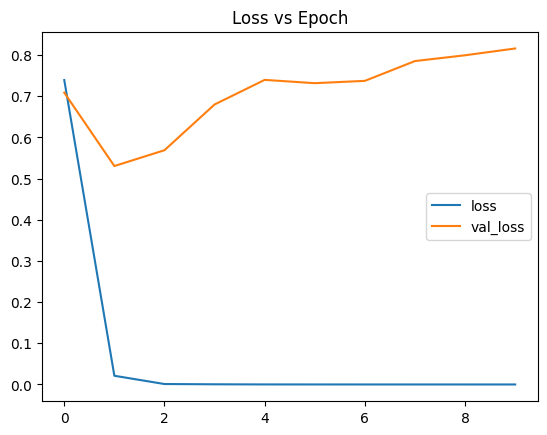

In [ ]:
# Load the history into a pandas Dataframe
df = pd.DataFrame(history.history)
# Make a plot for the loss
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch",ylim=(0,1))

<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

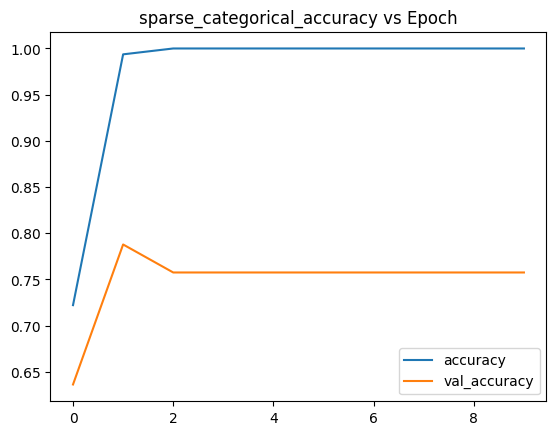

In [ ]:
# Make a plot for the accuracy
df.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch",ylim=(0,1))

##Modelo mejorado

Primeramente, para crear crear un mejor modelo, tomé como primer acercamiento el añadir más capas. En total, como se puede observar hay tres capas convolucionales con MaxPooling, como en el modelo anterior se tiene una capa de flatten y, una capa densa, una de dropout, la cual tiene como función ayudar a evitar el overfitting de nuestros datos.

Por otro lado, se modificó el optimizador a RMSprop y, se cambió el learning rate a .0001, lo cual ayudará con la velocidad del entrenamiento de nuestros datos, que como vimos anteriormente toma mucho tiempo incluso con un modelo de baja complejidad.

Por último se añadió EarlyStopping, el cuál sirve que cuando se identifiqué que la pérdida del conjunto de validación no mejora, detendrá el entrenamiento y, tomará al mejor resultado.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

model_improved = Sequential()
model_improved.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model_improved.add(MaxPooling2D((2, 2)))
model_improved.add(Conv2D(64, (3, 3), activation='relu'))
model_improved.add(MaxPooling2D((2, 2)))
model_improved.add(Conv2D(128, (3, 3), activation='relu'))
model_improved.add(MaxPooling2D((2, 2)))
model_improved.add(Flatten())
model_improved.add(Dense(128, activation='relu'))
model_improved.add(Dropout(0.5))
model_improved.add(Dense(3, activation='softmax'))

optimizer = RMSprop(learning_rate=0.0001)

model_improved.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Detiene el entrenamiento si la pérdida en validación no mejora durante 3 epochs

history = model_improved.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping])



Epoch 1/10
79/79 [==============================] - 635s 8s/step - loss: 0.9845 - accuracy: 0.5738 - val_loss: 0.8563 - val_accuracy: 0.5758
Epoch 2/10
79/79 [==============================] - 630s 8s/step - loss: 0.3734 - accuracy: 0.8917 - val_loss: 0.3800 - val_accuracy: 0.8182
Epoch 3/10
79/79 [==============================] - 630s 8s/step - loss: 0.1366 - accuracy: 0.9710 - val_loss: 0.4182 - val_accuracy: 0.7879
Epoch 4/10
79/79 [==============================] - 629s 8s/step - loss: 0.0774 - accuracy: 0.9806 - val_loss: 0.4317 - val_accuracy: 0.8182
Epoch 5/10
79/79 [==============================] - 630s 8s/step - loss: 0.0425 - accuracy: 0.9921 - val_loss: 0.4497 - val_accuracy: 0.8182


In [ ]:
# Evaluar en el conjunto de prueba
test_loss, test_accuracy = model_improved.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

12/12 [==============================] - 28s 2s/step - loss: 0.5047 - accuracy: 0.8118
Test Accuracy: 0.8118279576301575


Como se puede observar en los resultados del segundo modelo, este nos da mejores resultados gracias a los cambios realizados. Primeramente, para los datos de entrenamiento, ya no se llego a una precisión del 100%, no obstante puede que, dado que es de 99% pueda seguir habiendo un overfitting. Por otro lado, la precisión de los datos de validación, tuvo resultados mejores, siendo la más alta de 87%

<Axes: title={'center': 'Loss vs Epoch'}>

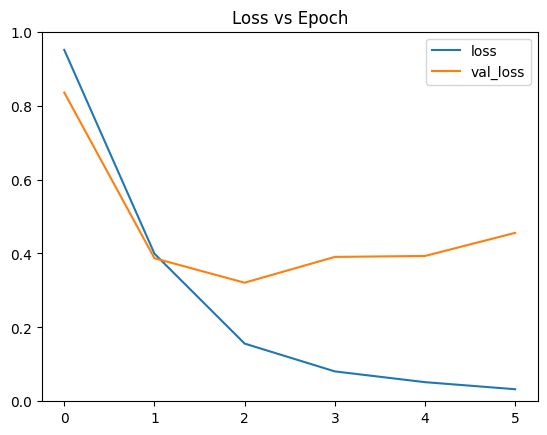

In [ ]:
# Load the history into a pandas Dataframe
df = pd.DataFrame(history.history)

# Make a plot for the loss
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch",ylim=(0,1))

<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

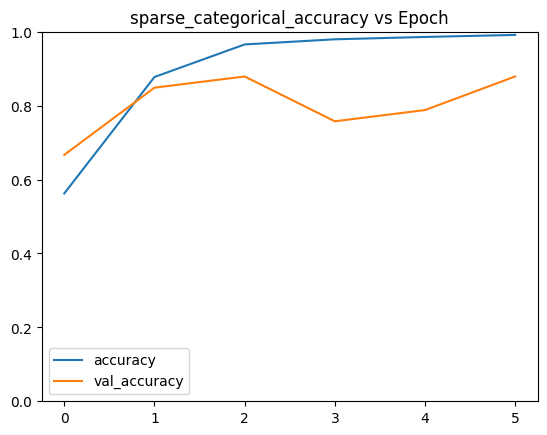

In [ ]:
# Make a plot for the accuracy
df.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch",ylim=(0,1))

##Conclusiones

Después de completar esta actividad, se puede afirmar que se cumplió con el objetivo de desarrollar un modelo inicial para clasificar las imágenes de piedra, papel y tijera utilizando una red neuronal convolucional. Con base a los resultados, se trabajó en la creación de un modelo mejorado, el cual demostró una mejora al abordar problemas de sobreajuste con la implementación de early stopping e inclusión de una capa de dropout y, al mismo tiempo, mostró una mejor precisión gracias a las capas adicionales y el uso de un nuevo optimizador.

Este modelo puede tener una aplicación más realista como clasificación de signos del lenguaje de señas para la interpretación de las expresiones de las personas, lo cual mejoraría significativamente la comunicación con individuos con discapacidades en este ámbito. En esta actividad no se logró realizar esto, debido a la capacidad de la memoria RAM, que impidió hacer una clasificación de 27 clases, siendoe estas una para cada letra del abecedario.

#Correcciones

Debido a que el dataset de validación contaba con muy pocas imágenes, se crea un generador distinto, el cual aplica diversas transformaciones como rotación, traslación, zoom, etc. a las imágenes cuando se hace el entrenamiento. Esto se hace con el fin de que el modelo sea capaz de generalizar nuevas imágenes. Cabe recalcar de nuevo que a pesar de que parezca que aún se tienen 33 imágenes, esto se debe a que el aumento de imágenes toma lugar en el entrenamiento, por lo que no se crean imágenes adicionales, sino que se generan dentro del proceso de entrenamiento.

##Corrección 2
Lo mismo se realiza con el conjunto de datos de entrenamiento, con el fin de evitar que suceda overfitting.

In [9]:
datagen_validation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,#Grados en los que se rotan las imágenes, esto se hace en el sentido de las manecillas del reloj
    width_shift_range=0.2,#Rango para mover las imágenes horizontalmente de manera aleatoria
    height_shift_range=0.2,#Rango para mover las imágenes verticalmente de manera aleatoria
    shear_range=0.2, #Rango para deformar el eje x
    zoom_range=0.2, #Rango para aplicar zoom a las imágenes
    horizontal_flip=True,#Se voltean aletaoriaente y de forma horizontal las imágenes
    fill_mode='nearest'#se usa para llenar píxeles recién creados después de una transformación,como se coloco nearset se usa el valor más cercano como relleno
)

validation_generator = datagen_validation.flow_from_directory(
    '/content/rock-paper-scissors/Rock-Paper-Scissors/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

#Se crean generadores para cargar nuestras imágenes por lotes para los datos de entranamiento

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,#Grados en los que se rotan las imágenes, esto se hace en el sentido de las manecillas del reloj
    width_shift_range=0.2,#Rango para mover las imágenes horizontalmente de manera aleatoria
    height_shift_range=0.2,#Rango para mover las imágenes verticalmente de manera aleatoria
    shear_range=0.2, #Rango para deformar el eje x
    zoom_range=0.2, #Rango para aplicar zoom a las imágenes
    horizontal_flip=True,#Se voltean aletaoriaente y de forma horizontal las imágenes
    fill_mode='nearest'#se usa para llenar píxeles recién creados después de una transformación,como se coloco nearset se usa el valor más cercano como relleno
)

train_generator = datagen_train.flow_from_directory(
    '/content/rock-paper-scissors/Rock-Paper-Scissors/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  #Definimos que es un problema de clasificación
)

Found 33 images belonging to 3 classes.
Found 2520 images belonging to 3 classes.


A diferencia del modelo anterior, este modelo agrega capas de BatchNormalization después de cada capa convolucional, lo cual ayuda que se normalicen las activaciones de cada capa, lo cual puede ayudar a acelerar el entrenamiento y disminuir la sensibilidad a la inicialización de pesos. A continuación, como se sugirió se agregó una capa de L2, que se encarga de la penalización de peso para prevenir overfitting. A continuación, también para el overfitting se añadió una capa densa con tasa de 0.5.Finalmente, como optimizador se añadió RMSprop con un learning rate a 0.0001, para que la tasa de aprendizaje se ajuste de manera dinámica durante el entrenamiento y,se añadió earlystopping para detener el entrenamiento si en 3 épocas la pérdida no mejora.

In [10]:
model_final = Sequential()
model_final.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model_final.add(BatchNormalization())#Capa de BatchMormalization
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(64, (3, 3), activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(128, (3, 3), activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Flatten())
model_final.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))#Capa L2 de regularización
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))#Capa dropout
model_final.add(Dense(3, activation='softmax'))

optimizer = RMSprop(learning_rate=0.0001)#Optimizador RMSprop

model_final.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)#Early stopping
history = model_final.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping])


Epoch 1/10
79/79 [==============================] - 884s 11s/step - loss: 3.3940 - accuracy: 0.7004 - val_loss: 6.3887 - val_accuracy: 0.3333
Epoch 2/10
79/79 [==============================] - 885s 11s/step - loss: 2.5617 - accuracy: 0.8317 - val_loss: 8.4529 - val_accuracy: 0.3333
Epoch 3/10
79/79 [==============================] - 881s 11s/step - loss: 2.0530 - accuracy: 0.8687 - val_loss: 10.7609 - val_accuracy: 0.3333
Epoch 4/10
79/79 [==============================] - 874s 11s/step - loss: 1.6339 - accuracy: 0.8921 - val_loss: 11.6090 - val_accuracy: 0.3333


Tomando en cuenta el entrenamiento podemos observar que la precisión es mayor a la del modelo anterior, sin embargo, la precisión con los datos de validación resulta menor, lo cual se debe a que ahora en este set se tienen más imágenes, por lo que, hay una menor probabilidad de que el modelo identifiqué cuáles son las imágenes de cada categoría, y con ello que se llegue a aprender las imágenes/datos de memoria.

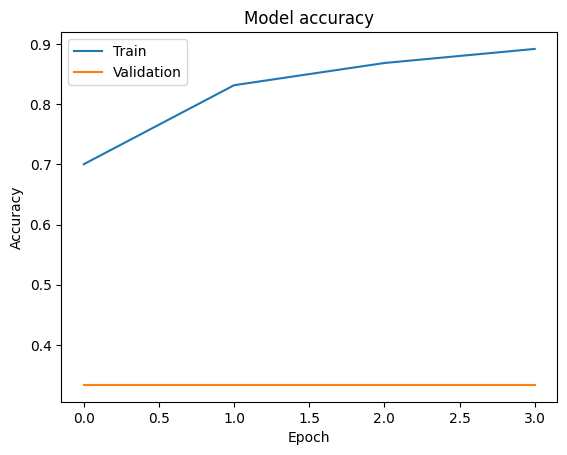

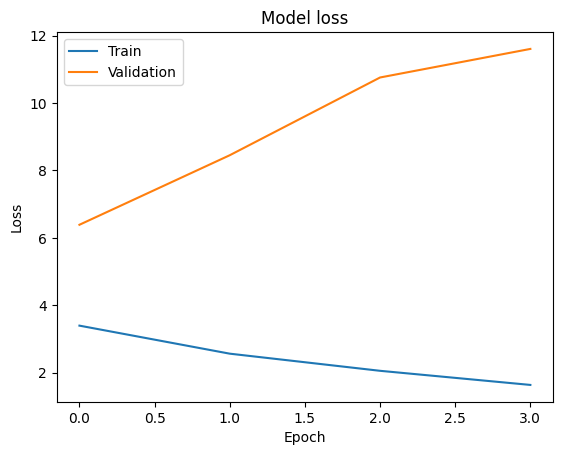

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Como se puede ver a continuación, la precisión del modelo es de 72%, la cual, es menor que el modelo anterior, sin embargo, es importante tomar en cuenta que con este modelo se puede tener por seguro que no existe un overfitting.

In [12]:
# Evaluar en el conjunto de prueba
test_loss, test_accuracy = model_final.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

12/12 [==============================] - 34s 3s/step - loss: 6.3713 - accuracy: 0.3333
Test Accuracy: 0.3333333432674408


Por último,usamos el siguiente código para identificar las tres clases en las que se clasfican las imágenes y, a continuación podemos subir una imágen para ver si el modelo es capaz de identificar cuál es. Tomemos en cuenta que este será más preciso conforme a la calidad que tenga la imágen, si cuenta con mucho ruido puede que no clasifique correctamente la imágen, por lo que aún se puede mejorar el modelo, sin embargo, si es posible que nos regresé una buena cantidad de resultados correctos

In [13]:
#Obtenemos las etiquetas e índices del generador de datos de entrenamiento
class_labels = train_generator.class_indices

#Identificación de las etiquetas y sus índices
print("Índices y Etiquetas:")
for label, index in class_labels.items():
    print(f"Índice {index}: Clase '{label}'")

Índices y Etiquetas:
Índice 0: Clase 'paper'
Índice 1: Clase 'rock'
Índice 2: Clase 'scissors'


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

#Definir la ruta de la imagen
new_image_path = '/content/piedra.jpg'

#Cargamos y se procesa la imagen que se selecciono anterormente, para que cumpla con las características que requeire el modelo
new_img = image.load_img(new_image_path, target_size=(img_height, img_width))
new_img_array = image.img_to_array(new_img)
new_img_array = np.expand_dims(new_img_array, axis=0)
new_img_array /= 255.0  # Normalización

#Usamos el modelo final para que nos haga la predicción
predictions = model_final.predict(new_img_array)

#Si imprimimos las predicciones del modelo nos dará la probabilidad de que la imagen sea cada una de las tres clasficiaciones
print(f'Probabilidades: {predictions}')

#Finalmente imprimimos la clase que el modelo predijo con base a nuestra imagen, con ello podemos ver que la clase pedicha fue la 1 que simboliza piedra, la cual, en este caso es correcta
predicted_class = np.argmax(predictions)
print(f'Clase predicha: {predicted_class}')

1/1 [==============================] - 0s 265ms/step
Probabilidades: [[3.223755e-05 9.146443e-01 8.532342e-02]]
Clase predicha: 1


#Conclusiones de las correcciones

La principal mejora del modelo se centra el overfitting, que es un problema común el entrenamiento de redes neuronales. Incorporando las capas de Batch Normalization es posible dar estabilidad con la normalización de las activaciones y, reducir la susceptibilidad a inicializaciones de peso. Igualmente, con la regularización L2 y al añadir de Dropout después de la capa densa se causa que el modelo penalice pesos grandes y no tenga dependencia de ninguna neurona durante el entrenamiento. Con ello, el modelo final puede generalizar los datos de manera más eficaz.

De igual forma, debido a que se aumentaron los datos durante el entrenamiento, aunque no se generan físicamente más imágenes, las transformaciones son capaces de simular un conjunto de datos más grande. Esto combinado con la adaptación del optimizador a RMSprop y el uso de Early Stopping, ayuda a que el modelo tenga un rendimiento más consistente en los datos no vistos.

Por lo mencionado anteriormente,podemos concluir que, gracias a la generación de las transformaciones y, al tratamiento del overfitting, con los cambios generados, este modelo resulta más confiable que los anteriores.